## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [2]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"
IMAGES_OUTPUT_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Images/"

## Defining Analysis Functions

In [3]:
def import_data(model_name="univariate_baseline"):
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    return true, predicted

In [4]:
def compute_residuals(true, pred):
    residuals = np.sum(true-pred, axis=1)
    residuals = ((residuals)/true.shape[1])/ 1000
    return residuals

In [5]:
def generate_boxplot(datasets=[],title="DEFAULT", ylab="Residuals (Mbps)",xlab=[], colours=[],
                      output_folder=IMAGES_OUTPUT_FOLDER, ylim=()):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylab)
    box = ax.boxplot(datasets, whis=(5,95), patch_artist=True, notch=True, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'fuchsia'})
    ax.set_xticklabels(xlab)
    if colours:
        for bplot, colour in zip(box["boxes"], colours):
            bplot.set_color(colour)
    if ylim:
        ax.set_ylim(ylim)
    ax.yaxis.grid(True)
    plt.xticks(rotation=-45)
    plt.savefig(output_folder+title+".png", dpi=320)

In [6]:
def get_variance(data):
    return np.var(data)

In [7]:
def get_std(data):
    return np.std(data)

In [8]:
def get_ts_residuals(true, pred):
        residuals = true-pred
        residuals = residuals / 1000
        return residuals

In [9]:
import seaborn as sns
def time_step_boxpots(residuals=[], model_names=[], title="", xlim=()):
    df = pd.DataFrame()
    for model, residuals in zip(model_names, residuals):
        for i in range(residuals.shape[1]):
            temp_df = pd.DataFrame()
            temp_df["Residuals (Mb)"] = residuals[:,i]
            temp_df["Time Step"] = i+1
            temp_df["Model"] = model
            df = pd.concat([df, temp_df])
    sns.set_theme(style="whitegrid")
    box = sns.boxplot(x="Residuals (Mb)", y="Time Step",
                hue="Model",
                data=df, orient="h", whis=(5,95), saturation=1, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'pink'})
    if xlim:
        box.set_xlim(xlim)
    box.set_title(title)
    box.set_ylabel("Future Time Step (seconds)")
    

In [ ]:
def get_mape(true, predicted, epsilon=50):
    denominator = np.squeeze(true) + epsilon
    try:
        mape = np.mean(np.abs((np.squeeze(true) - predicted)/denominator))*100
    except Exception as e:
        print(e)
        mape = "n/a"
    return mape

In [ ]:
def get_mse(true, predicted):
    mse = np.mean(np.power(np.squeeze(true)-predicted, 2))
    return mse

In [ ]:
def get_mae(true, predicted):
    mae = np.mean(np.abs(np.squeeze(true)-predicted))
    return mae

In [10]:
def carry_out_analysis(prefix="univariate", title_prefix="Univariate"):
    for dataset in ["low", "medium", "high", 1]:
        if dataset == 1:
            base_true, base_pred = import_data(model_name="{}_baseline".format(prefix))
            multiOne_true, multiOne_pred = import_data(model_name="{}_multiOne".format(prefix))
            multiAll_true, multiAll_pred = import_data(model_name="{}_multiAll".format(prefix))

            # Get Residuals
            base_resid = get_ts_residuals(base_true, base_pred)
            multiOne_resid = get_ts_residuals(multiOne_true, multiOne_pred)
            multiAll_resid = get_ts_residuals(multiAll_true, multiAll_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resid, multiOne_resid, mutliAll_resid], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences")

            # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)
            multiAll_std = get_std(multiAll_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(multiOne_true, multiOne_pred)
            multiAll_mape = get_mape(multiAll_true, multiAll_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(multiOne_true, multiOne_pred)
            multiAll_mse = get_mse(multiAll_true, multiAll_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(multiOne_true, multiOne_pred)
            multiAll_mae = get_mae(multiAll_true, multiAll_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mb)", " Resids std (Mb)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resid), base_std, base_mape, base_mse, multiOne_mae])
            table.add_row(["Multistage One",np.mean(multiOne_resid), multiOne_std, multiOne_mape, multiOne_mse, multiOne_mae])
            table.add_row(["Multistage All",np.mean(multiAll_resid), multiAll_std, multiAll_mape, multiAll_mse, multiAll_mae])
            print("Residuals of All Sequences Test Set")
            print(table)
            
        else:
            base_true, base_pred = import_data(model_name="{}_baseline_{}".format(prefix, dataset))
            single_true, single_pred = import_data(model_name="{}_multiOne_{}".format(prefix, dataset))

            # Get Residuals
            base_resid = get_ts_residuals(base_true, base_pred)
            multiOne_resid = get_ts_residuals(multiOne_true, multiOne_pred)
            multiAll_resid = get_ts_residuals(multiAll_true, multiAll_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resid, multiOne_resid], model_names=["Baseline", "{} Only".format(dataset)], title="Model Performance on {} Test Sequences".format(dataset))

            # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(multiOne_true, multiOne_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(multiOne_true, multiOne_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(multiOne_true, multiOne_pred)
            multiAll_mae = get_mae(multiAll_true, multiAll_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mb)", " Resids std (Mb)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resid), base_std, base_mape, base_mse, multiOne_mae])
            table.add_row(["{} Only".format(dataset),np.mean(multiOne_resid), multiOne_std, multiOne_mape, multiOne_mse, multiOne_mae])
            print("Residuals of {} Sequences Test Set".format(dataset))
            print(table)



        


# Individual Models

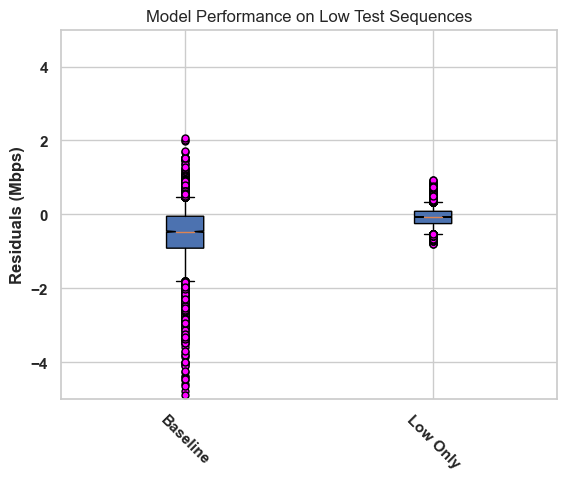

In [59]:
true, pred = import_data("solo_low_all_network")
low = compute_residuals(true, pred)
low_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_low")
base_low = compute_residuals(true, pred)
base_low_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences", ylim=(-5,5))

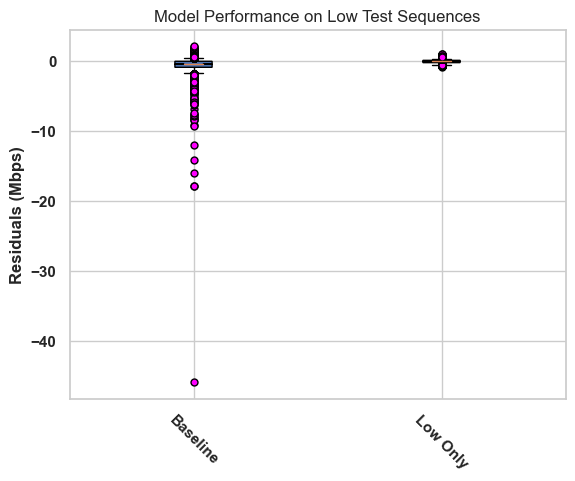

In [94]:
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences")

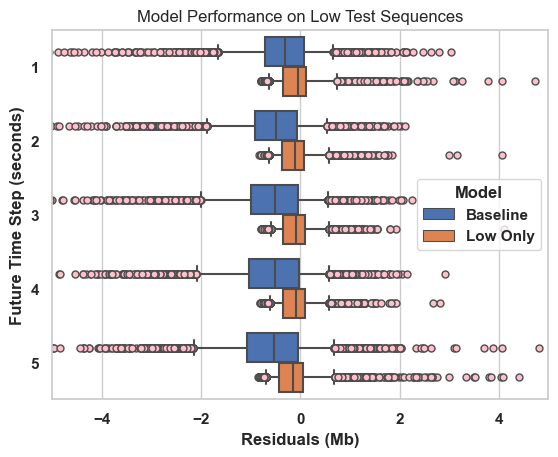

In [61]:
time_step_boxpots([base_low_ts, low_ts], model_names=["Baseline", "Low Only"], xlim=(-5,5), title="Model Performance on Low Test Sequences")

In [63]:
base_std = get_std(base_low)
low_std = get_std(low)
table_low = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_low.add_row(["Baseline", np.mean(base_low_ts), np.std(base_low_ts)])
table_low.add_row(["Low Only Model", np.mean(low_ts), np.std(low_ts)])
print("Residuals of Low Sequences Test Set")
print(table_low)

Residuals of Low Sequences Test Set
+----------------+----------------------+--------------------+
|     Model      |      Mean (Mb)       | Standard Dev (Mb)  |
+----------------+----------------------+--------------------+
|    Baseline    | -0.5860041683526068  | 1.2697900648101184 |
| Low Only Model | -0.08374551402536326 | 0.4151138109984922 |
+----------------+----------------------+--------------------+


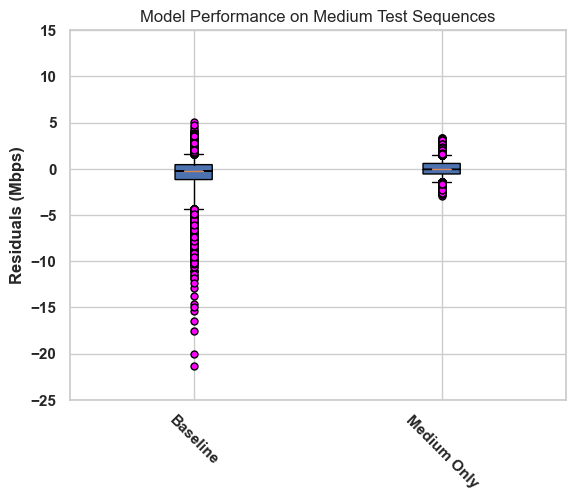

In [74]:
true, pred = import_data("solo_medium_all_network")
medium = compute_residuals(true, pred)
medium_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_medium")
base_medium = compute_residuals(true, pred)
base_medium_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_medium, medium], xlab=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences", ylim=(-25,15))

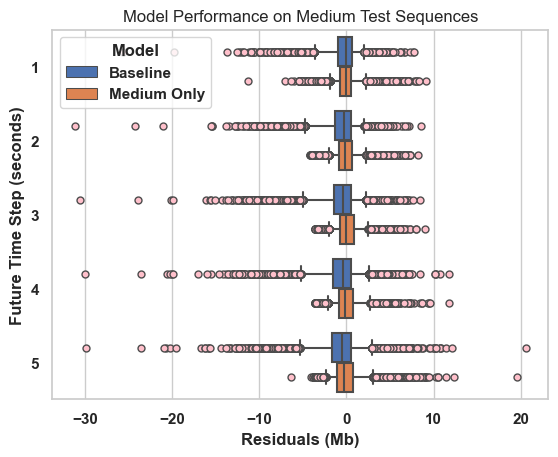

In [75]:
time_step_boxpots([base_medium_ts, medium_ts], model_names=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences")


In [73]:
base_std = get_std(base_medium_ts)
medium_std = get_std(medium_ts)
table_medium = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_medium.add_row(["Baseline",np.mean(base_medium_ts), base_std])
table_medium.add_row(["Medium Only Model",np.mean(medium_ts), medium_std])
print("Residuals of Medium Sequences Test Set")
print(table_medium)

Residuals of Medium Sequences Test Set
+-------------------+----------------------+--------------------+
|       Model       |      Mean (Mb)       | Standard Dev (Mb)  |
+-------------------+----------------------+--------------------+
|      Baseline     | -0.6186391210249489  | 2.3154437980716804 |
| Medium Only Model | 0.007299761038765521 | 1.4568877461239058 |
+-------------------+----------------------+--------------------+


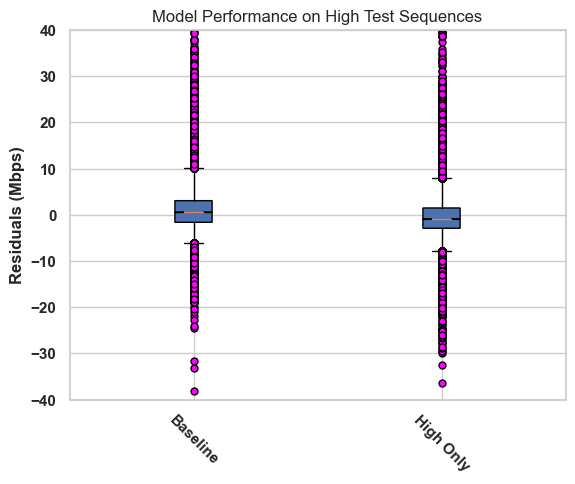

In [78]:
true, pred = import_data("solo_high_all_network")
high = compute_residuals(true, pred)
high_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_high")
base_high = compute_residuals(true, pred)
base_high_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_high, high], xlab=["Baseline", "High Only"], title="Model Performance on High Test Sequences", ylim=(-40, 40))

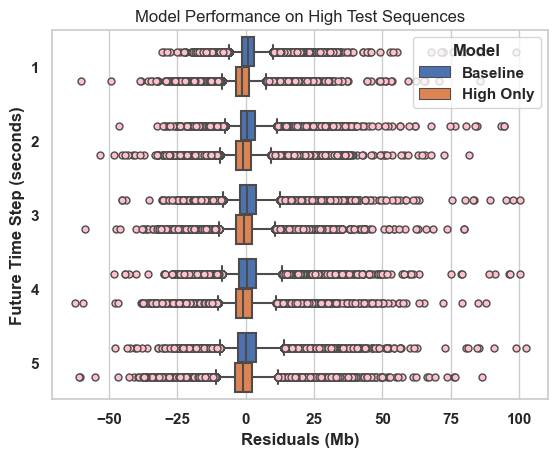

In [79]:
time_step_boxpots([base_high_ts, high_ts], model_names=["Baseline", "High Only"], title="Model Performance on High Test Sequences")


In [80]:
base_std = get_std(base_high_ts)
high_std = get_std(high_ts)
table_high = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_high.add_row(["Baseline",np.mean(base_high_ts), base_std])
table_high.add_row(["High Only Model",np.mean(high_ts), high_std])
print("Residuals of High Sequences Test Set")
print(table_high)

Residuals of High Sequences Test Set
+-----------------+---------------------+-------------------+
|      Model      |      Mean (Mb)      | Standard Dev (Mb) |
+-----------------+---------------------+-------------------+
|     Baseline    |  1.1603552227945595 | 7.049726575529738 |
| High Only Model | -0.5036992952485793 |  6.93367129172688 |
+-----------------+---------------------+-------------------+


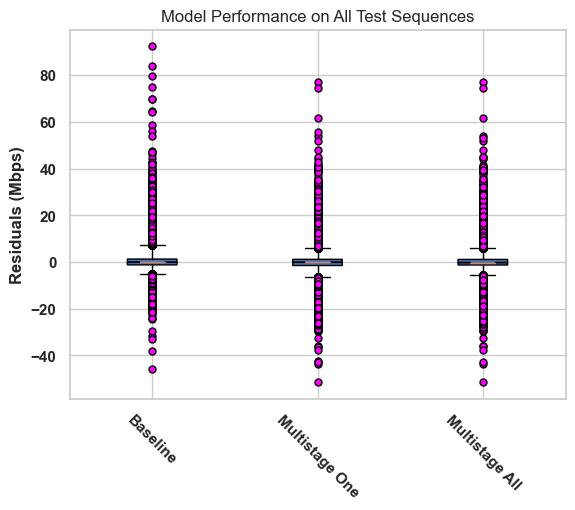

In [82]:
true, pred = import_data("standardized_multiOne")
multi_one = compute_residuals(true, pred)
multi_one_ts = get_ts_residuals(true, pred)

true, pred = import_data("standardized_multiAll")
multi_all = compute_residuals(true, pred)
multi_all_ts = get_ts_residuals(true, pred)

true, pred = import_data("standard_4_all_network_baseline")
base = compute_residuals(true, pred)
base_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base, multi_one, multi_all], xlab=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences")
# generate_boxplot(datasets=[base, multi_one], xlab=["Baseline", "Multistage One"], title="Model Performance on all Test Sequences")

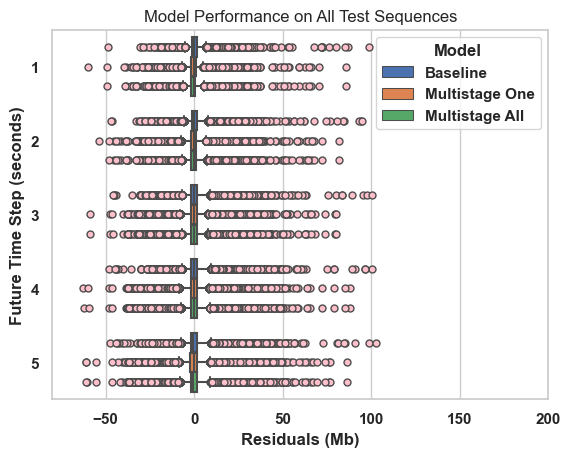

In [93]:
time_step_boxpots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences", xlim=(-80, 200))


In [68]:
base_std = get_std(base)
multi_one_std = get_std(multi_one)
multi_all_std = get_std(multi_all)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table.add_row(["Baseline",np.mean(base), base_std])
table.add_row(["Multistage One",np.mean(multi_one), multi_one_std])
table.add_row(["Multistage All",np.mean(multi_all), multi_all_std])
print("Residuals of All Sequences Test Set")
print(table)

Residuals of All Sequences Test Set
+----------------+---------------------+--------------------+
|     Model      |      Mean (Mb)      | Standard Dev (Mb)  |
+----------------+---------------------+--------------------+
|    Baseline    |  1.7475118146081794 | 22.326735321061207 |
| Multistage One | -0.5489678355247941 | 22.36855449980445  |
| Multistage All |  0.166101626871677  | 21.740109912761376 |
+----------------+---------------------+--------------------+


In [32]:
print("Residuals of Low Sequences Test Set")
print(table_low)
print("==============================================================\n")
print("Residuals of Medium Sequences Test Set")
print(table_medium)
print("==============================================================\n")
print("Residuals of High Sequences Test Set")
print(table_high)
print("==============================================================")

Residuals of Low Sequences Test Set
+----------------+----------------------+--------------------+
|     Model      |      Mean (Mb)       | Standard Dev (Mb)  |
+----------------+----------------------+--------------------+
|    Baseline    | -2.9300208417630347  | 6.099708539326167  |
| Low Only Model | -0.41872757012681633 | 1.2964441741282975 |
+----------------+----------------------+--------------------+

Residuals of Medium Sequences Test Set
+-------------------+----------------------+-------------------+
|       Model       |      Mean (Mb)       | Standard Dev (Mb) |
+-------------------+----------------------+-------------------+
|      Baseline     | -3.0931956051247442  | 9.857150766565072 |
| Medium Only Model | 0.036498805193827595 | 4.408891961623033 |
+-------------------+----------------------+-------------------+

Residuals of High Sequences Test Set
+-----------------+--------------------+--------------------+
|      Model      |     Mean (Mb)      | Standard Dev (M

[2 2 2 ... 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[2 2 2 ... 1 1 2]


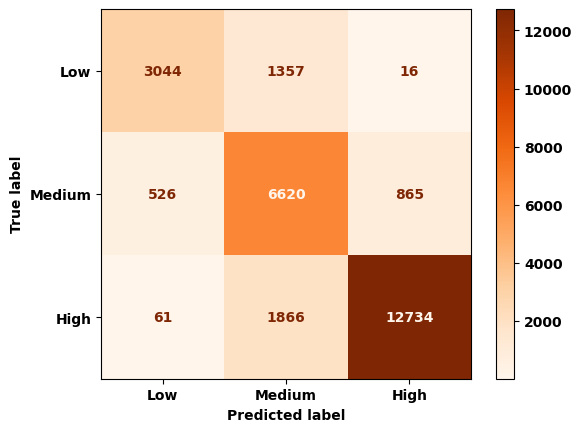

In [33]:
true, pred = import_data("solo_all_network_classifier")
print(true)
print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)
conf_matrix = confusion_matrix(true, pred)
display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
display_conf.plot(cmap="Oranges")
plt.show()